In [1]:
# Import necessary PySpark library SparkSession to read the data
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import numpy as np
import pandas as pd
import math
import datetime
import os
import matplotlib.pyplot as plt
from pyspark.sql.functions import hour,dayofmonth,month,year, mean
from pyspark.sql.functions import concat_ws,col,input_file_name
from pyspark.sql.functions import * 

VBox()

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
input_bucket = 's3://binaincephill'
input_path = '/pyspark/Coins'

df_binance = spark.read.parquet(input_bucket + input_path+'/*.parquet')
df_binance = df_binance.withColumn('filename', input_file_name())
df_binance = df_binance.withColumn('pair', substring('filename', 33, 9))
df_binance.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------+-------+-------+--------+------------------+----------------+---------------------------+----------------------------+-------------------+--------------------+------+
|   open|   high|    low|  close|  volume|quote_asset_volume|number_of_trades|taker_buy_base_asset_volume|taker_buy_quote_asset_volume|          open_time|            filename|  pair|
+-------+-------+-------+-------+--------+------------------+----------------+---------------------------+----------------------------+-------------------+--------------------+------+
|4261.48|4261.48|4261.48|4261.48|1.775183|         7564.9067|               3|                   0.075183|                   320.39084|2017-08-17 04:00:00|s3://binaincephil...|arquet|
|4261.48|4261.48|4261.48|4261.48|     0.0|               0.0|               0|                        0.0|                         0.0|2017-08-17 04:01:00|s3://binaincephil...|arquet|
|4280.56|4280.56|4280.56|4280.56|0.261074|          1117.543|               2|  

In [3]:
group_cols = [year('open_time').alias('year'),month("open_time").alias('month'),dayofmonth("open_time").alias('day')]
w = df_binance.groupBy(group_cols).agg(mean("close").alias("average_close")).orderBy('year')
w = w.select(concat_ws('-',w.year,w.month,w.day).alias("date"),'average_close')
w = w.select(F.to_timestamp(col("date"),"yyyy-M-d").alias('date'),'average_close')
w= w.filter("date between '2017-01-01' and '2017-12-31'")
w.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------------+
|               date|     average_close|
+-------------------+------------------+
|2017-09-09 00:00:00|224.94591830029958|
|2017-10-03 00:00:00|109.24896211929921|
|2017-10-30 00:00:00| 93.23637899934359|
|2017-11-07 00:00:00|  86.4514935660515|
|2017-09-17 00:00:00|149.06116085565841|
|2017-12-06 00:00:00|100.51918277915529|
|2017-11-08 00:00:00| 87.49841283532955|
|2017-10-16 00:00:00|111.99180992287653|
|2017-10-21 00:00:00|108.04691224172873|
|2017-09-06 00:00:00|206.51737968368207|
|2017-11-13 00:00:00| 78.07183343184916|
|2017-11-02 00:00:00|  92.3973014873495|
|2017-08-18 00:00:00| 348.6162329154206|
|2017-11-29 00:00:00|  89.6204816976934|
|2017-12-15 00:00:00|127.46957241919307|
|2017-08-30 00:00:00| 260.0476982146321|
|2017-11-19 00:00:00| 82.23049962207409|
|2017-12-08 00:00:00|119.07679304903074|
|2017-09-14 00:00:00|151.90486830371515|
|2017-09-01 00:00:00|248.82238136025242|
+-------------------+------------------+
only showing top

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

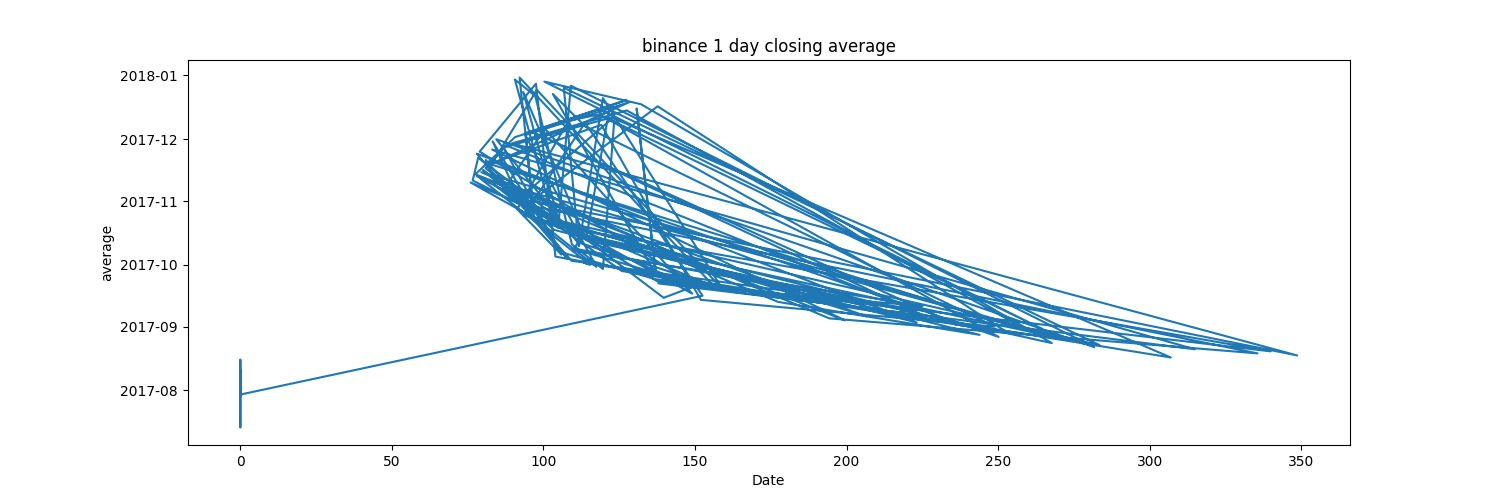

In [4]:
avg = [val.average_close for val in w.select('average_close').collect()]
date = [val.date for val in w.select('date').collect()]
plt.figure(figsize = (15, 5))
plt.plot(avg,date)
plt.ylabel('average')
plt.xlabel('Date')
plt.title('binance 1 day closing average')
plt.show()
%matplot plt

In [5]:
df = df_binance.limit(10000).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#df.drop(['pair', 'open_time', 'close'], 1, inplace=True)
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          open  ...    pair
0  4261.479980  ...  arquet
1  4261.479980  ...  arquet
2  4280.560059  ...  arquet
3  4261.479980  ...  arquet
4  4261.479980  ...  arquet

[5 rows x 12 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

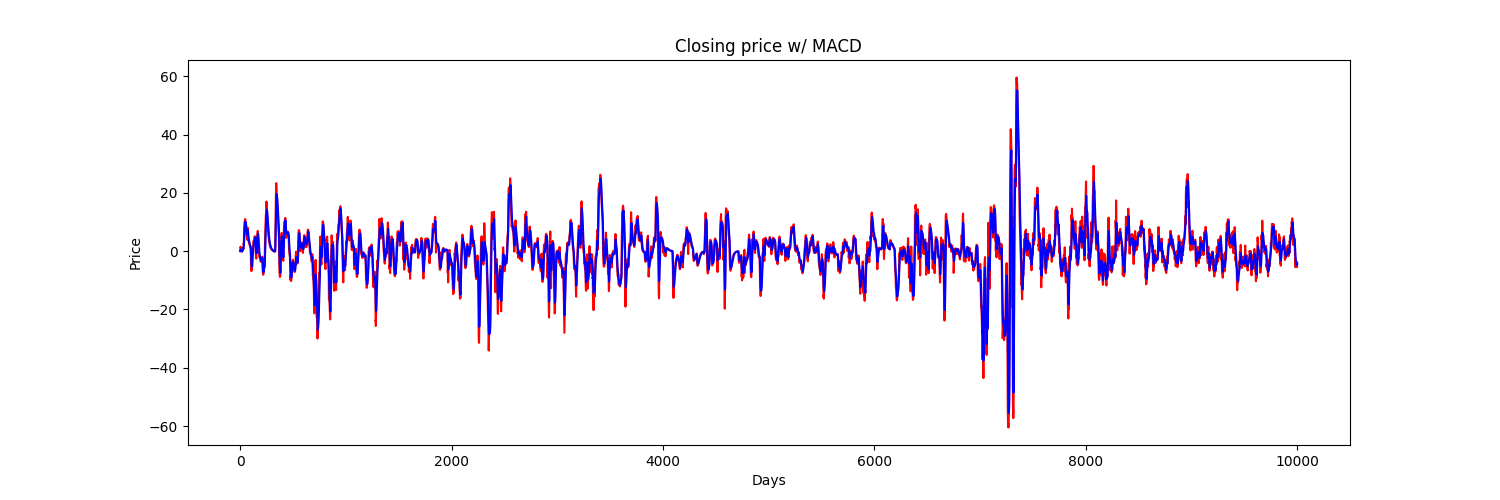

In [7]:
df.set_index('open_time')

short_ema = df.close.ewm(span = 12, adjust = False).mean()
long_ema = df.close.ewm(span = 26, adjust = False).mean()

macd = short_ema - long_ema
signal = macd.ewm(span = 9, adjust = False).mean()

# Closing prince over the time
plt.figure(figsize=(15,5))
#plt.plot(df.open.values, color = 'red', label = 'open')
plt.plot(df.close.values, color = 'green', label = 'close')
#plt.plot(df.low.values, color = 'blue', label = 'low')
#plt.plot(df.high.values, color = 'black', label = 'high')
plt.title('Closing price of all pairs')
plt.xlabel('Tme [days]')
plt.ylabel('Pice')
plt.legend(loc = 'best')
plt.show()
%matplot plt

# MACD over the time moving average
plt.figure(figsize = (15, 5))
plt.plot(df.index, macd, label = 'Binance MACD', color = 'red')
plt.plot(df.index, signal, label = 'Signal line', color = 'blue')
plt.title("Closing price w/ MACD")
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()
%matplot plt

In [8]:
y_close = [val.close for val in df_binance.limit(10000).select('close').collect()]
x_open_time = [val.open_time for val in df_binance.limit(10000).select('open_time').collect()]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

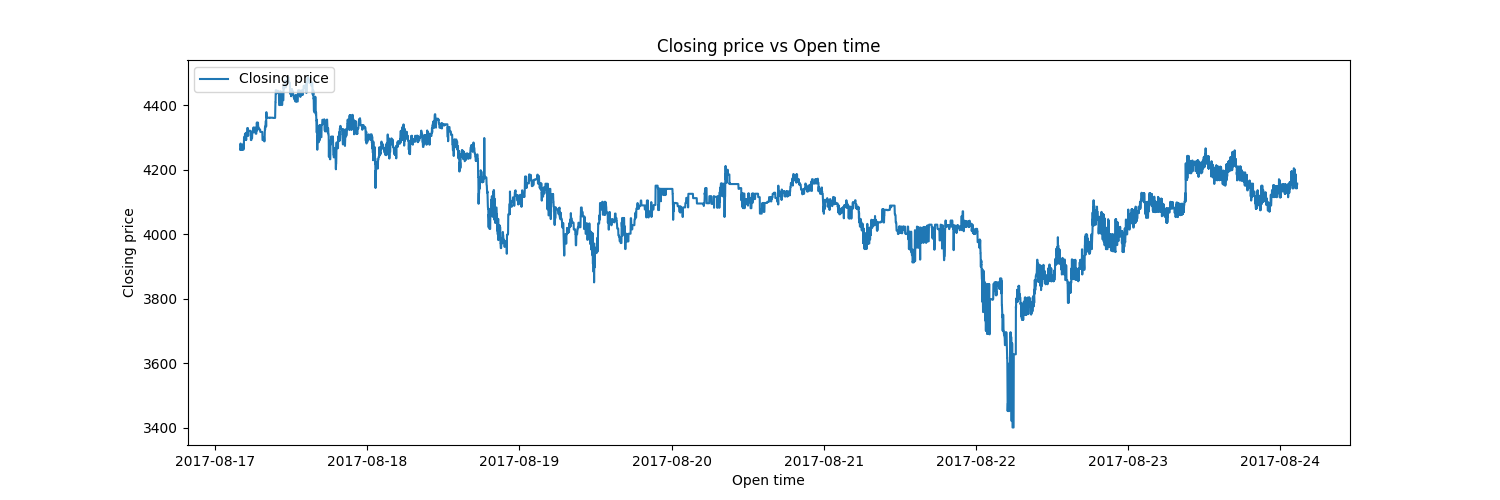

In [9]:
plt.figure(figsize = (15, 5))
plt.plot(x_open_time, y_close)
plt.ylabel('Closing price')
plt.xlabel('Open time')
plt.title('Closing price vs Open time')
plt.legend(['Closing price'], loc = 'upper left')
plt.show()
%matplot plt

In [10]:
df_binance_top_10 = df_binance.groupBy("pair").mean("close").limit(10000)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df_binance_top_10.orderBy('avg(close)').limit(10).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|     pair|          avg(close)|
+---------+--------------------+
|     quet|3.546487212019786...|
|SDT.parqu|   0.455184145392434|
|DT.parque|   3.375365256991278|
|USDT.parq|   8.470262893170023|
| .parquet|  17.560401577326633|
|SD.parque|   19.95756934295276|
|T.parquet|   37.07013225941654|
|  parquet|  1774.6478096643718|
|    rquet|  42175.659766815086|
|   arquet|   6984513.531196098|
+---------+--------------------+

In [12]:
df_ethbtc = spark.read.parquet(input_bucket+input_path+'/ETH-BTC.parquet')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
y_close = [val.close for val in df_ethbtc.select('close').collect()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
x_open_time = [val.open_time for val in df_ethbtc.select('open_time').collect()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
df_btceth = spark.read.parquet(input_bucket+input_path+'/BTC-USDT.parquet')

y_close_b = [val.close for val in df_btceth.select('close').collect()]
x_open_time_b = [val.open_time for val in df_btceth.select('open_time').collect()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

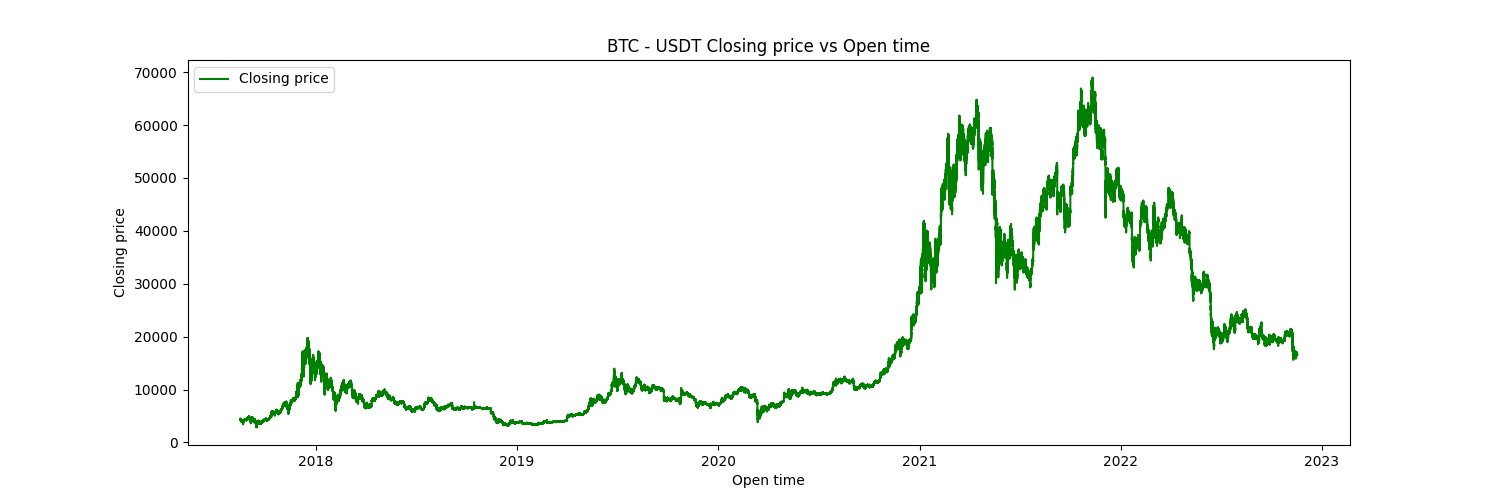

In [16]:
plt.figure(figsize = (15, 5))
plt.plot(x_open_time, y_close, color = 'blue', label = 'ETH')
plt.ylabel('Closing price')
plt.xlabel('Open time')
plt.title('ETH - BTC Closing price vs Open time')
plt.legend(['Closing price'], loc = 'upper left')
plt.show()

plt.figure(figsize = (15, 5))
plt.plot(x_open_time_b, y_close_b, color = 'green', label = 'ETH')
plt.ylabel('Closing price')
plt.xlabel('Open time')
plt.title('BTC - USDT Closing price vs Open time')
plt.legend(['Closing price'], loc = 'upper left')
plt.show()
%matplot plt